# Example Code for using the $\partial I/ \partial V$ Fitting Routines

Import the needed packages to run the test script.

In [1]:
import qetpy as qp
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
np.random.seed(0)

%matplotlib inline

Set all of the necessary parameters for initalizing the class, as well as specify the TES parameters that we will use to simulate a TES square wave response.

In [2]:
# Setting various parameters that are specific to the dataset
rsh = 5e-3
rbias_sg = 10000
fs = 1.25e6
sgfreq = 100
sgamp = 0.009381 / rbias_sg

rfb = 1250
loopgain = 10
drivergain = 4
adcpervolt = 65536 / 2
tracegain = rfb * loopgain * drivergain * adcpervolt

true_params = {
    'rsh': rsh,
    'rp': 0.006,
    'r0': 0.0756,
    'r0_err':0.001,
    'i0': 1e-6,
    'i0_err': 1e-8,
    'beta': 2,
    'l': 10,
    'L': 1e-7,
    'tau0': 500e-6,
    'gratio': 0.5,
    'tau3': 1e-3,
    'dt':0
}

Make simulated data, where we simply have a TES square response with added white noise (not exactly physical, but this is just a demo!).

In [3]:
n_bins = int(4 * fs / sgfreq)
noise_amplitude = 1e-7
rawnoise = np.random.normal(loc=0.0,
                             scale=noise_amplitude,
                             size=(300, n_bins))

In [4]:
t = np.arange(rawnoise.shape[-1]) / fs
didv_response = qp.squarewaveresponse(
    t, sgamp, sgfreq, true_params,dutycycle=0.5, rsh=rsh
)

rawtraces = didv_response + rawnoise

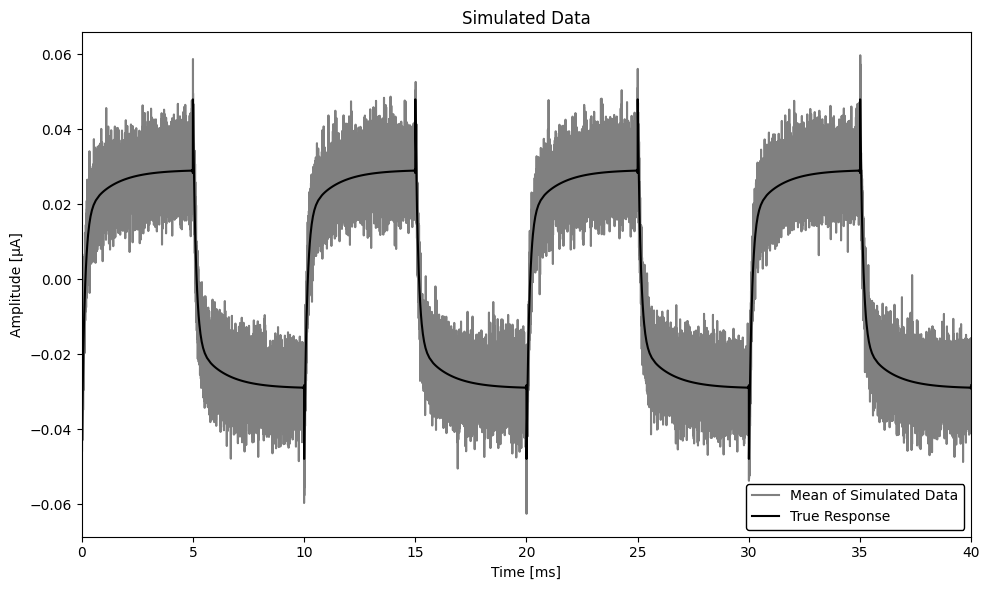

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    t * 1e3,
    rawtraces.mean(axis=0) * 1e6,
    color='gray',
    label='Mean of Simulated Data',
)
ax.plot(
    t * 1e3,
    didv_response * 1e6,
    color='k',
    label='True Response',
)
ax.set_ylabel('Amplitude [μA]')
ax.set_xlabel('Time [ms]')
ax.set_title('Simulated Data')
ax.set_xlim(0, 40)
ax.legend(loc='lower right', edgecolor='k', framealpha=1)
fig.tight_layout()



## Using the `DIDV` Class

Run the processing package on the data.

Note that the parameterization used by this class is such that there are no degenerate fitting parameters. Depending on the fit, the model changes.

From the Notes in `DIDV.dofit`:

    Notes
    -----
    Depending on the fit, there are three possible models to be
    used with different parameterizations:

    1-pole model
        - has the form:
            dV/dI = A * (1.0 + 2.0j * pi * freq * tau2)

    2-pole model
        - has the form:
            dV/dI = A * (1.0 + 2.0j * pi * freq * tau2)
                  + B / (1.0 + 2.0j * pi * freq * tau1)

    3-pole model
        - note the placement of the parentheses in the last term of
          this model, such that pole related to `C` is in the
          denominator of the `B` term
        - has the form: 
            dV/dI = A * (1.0 + 2.0j * pi * freq * tau2)
                  + B / (1.0 + 2.0j * pi * freq * tau1
                  - C / (1.0 + 2.0j * pi * freq * tau3))


In [6]:
didvfit = qp.DIDV(
    rawtraces,
    fs,
    sgfreq,
    sgamp,
    rsh,
    tracegain=1.0,
    r0=true_params['r0'], # the expected r0 should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    rp=true_params['rp'], # the expected rp should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    dt0=-1e-6, # a good estimate of the time shift value will likely speed up the fit/improve accuracy
    add180phase=False, # if the fits aren't working, set this to True to see if the square wave is off by half a period
)


Do Fit

In [7]:
# didvfit.dofit(1) # we skip the 1-pole fit, as it takes a long time to run due to being a bad model.
didvfit.dofit(2)
didvfit.dofit(3)

Small signal parameter calculation

In [8]:
didvfit.calc_smallsignal_params(biasparams=true_params)

INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 


Let's look at the fit parameters for the fits.

In [9]:
result2 = didvfit.fitresult(2)
result3 = didvfit.fitresult(3)

Each of these `result` variables are dictionaries that contain various information that have to do with the fits, as shown by looking at the keys.

In [10]:
print(result3.keys())
pprint(result3['params'])

dict_keys(['lgcfix', 'params_array', 'params', 'cov', 'errors', 'falltimes', 'cost', 'offset', 'offset_err', 'biasparams', 'smallsignalparams', 'ssp_light', 'didv0', 'dpdi0', 'dpdi0_err'])
{'A': 0.2403055798308573,
 'B': -0.33881232933390965,
 'C': -0.056544917950646624,
 'dt': -2.545795777222618e-07,
 'tau1': -5.493371626654308e-05,
 'tau2': 7.276349682272303e-07,
 'tau3': 0.0010171251173122435}


- `'lgcfix'`  contains boolean array with parameters that have been fixed (None is no parameter fixed)
- `'params'` contains the fitted parameters from the minimization method (in the case of `DIDV`, this is in the parameterization used by the fitting algorithm)
- `'cov'` contains the corresponding covariance matrix
- `'errors'` is simply the square root of the diagonal of the covariance matrix
- `'smallsignalparams'` contains the corresponding parameters in the small-signal parameterization of the complex impedance, as shown by [Irwin and Hilton](https://doi.org/10.1007/10933596_3) for the two-pole model and [Maasilta](https://doi.org/10.1063/1.4759111) for the three-pole model.
- `'falltimes'` contains the physical fall times of the specified model
- `'cost'` is the value of the chi-square at the fitted values
- `'didv0'` is the zero frequency component of the $\partial I / \partial V$ fitted model.

There are a handful of plotting functions that can be used to plot the results, where we use two of them below.

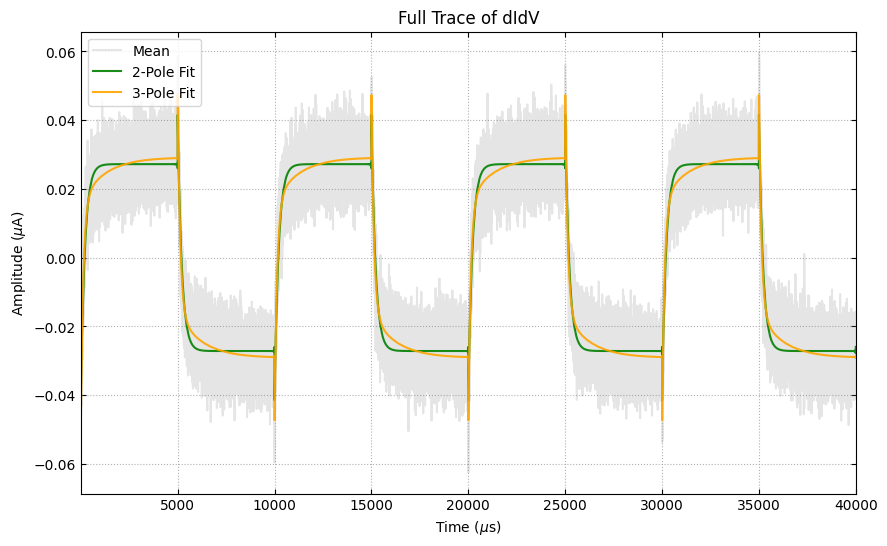

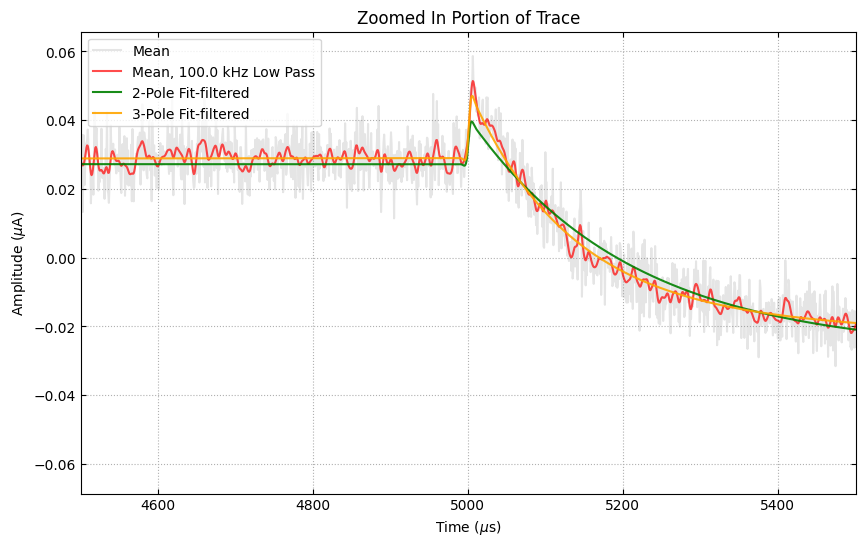

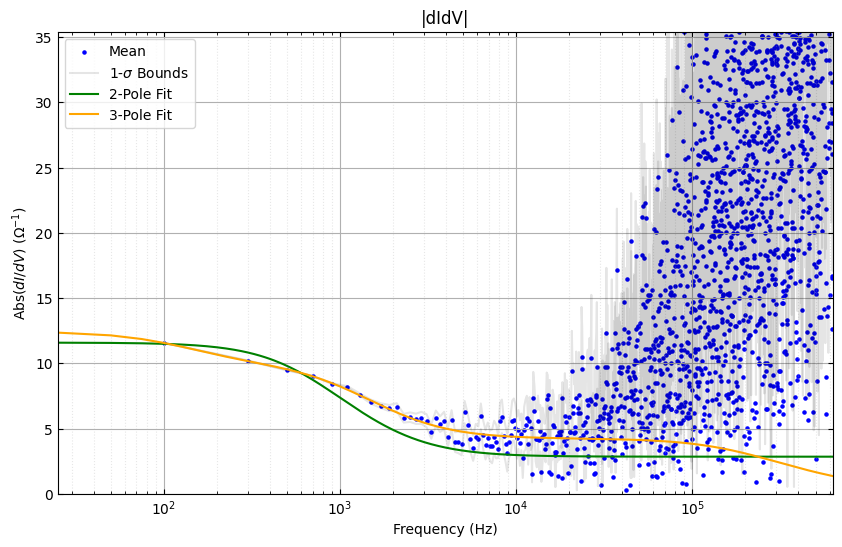

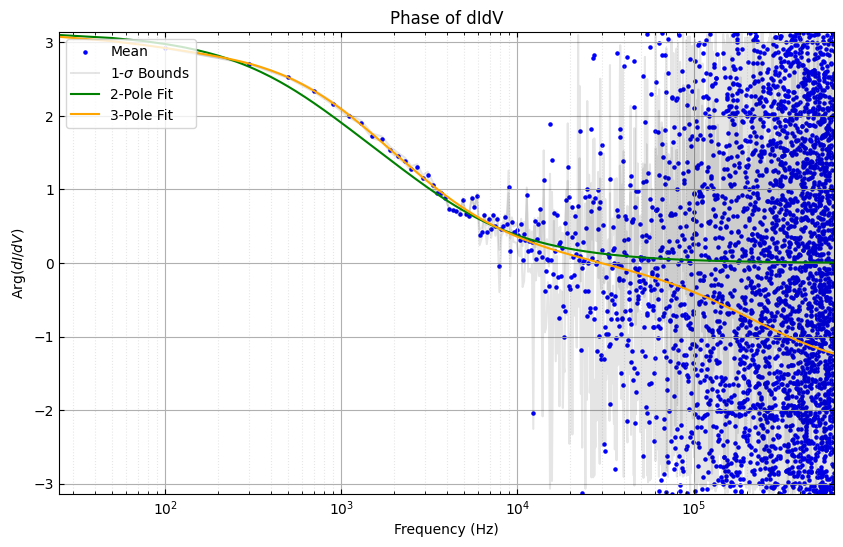

In [11]:
didvfit.plot_full_trace()
# didvfit.plot_single_period_of_trace()
# didvfit.plot_didv_flipped()
# didvfit.plot_re_vs_im_dvdi()
# didvfit.plot_re_im_didv()

didvfit.plot_zoomed_in_trace(zoomfactor=0.1, lp_cutoff=1e5)
didvfit.plot_abs_phase_didv()

## Advanced Usage: `Fixing fit parameters and bounds`

Various arguments can be added to DIDV `dofit` functions:

 * `bounds`: 2-tuple of 1D numpy array (length=nb parameters) for lower/upper limits for each parameters
 * `lgcfix`: 1D numpy array dtype=boolean (length=nb parameters) to fix parameters. The value of the fixed parameters is the guessed value
 * `guess_params`: 1D numpy array(length=nb parameters) with guessed initial values for each parameters (overwriting   
    calculated guess from _guessdidvparams function or 2-pole fit result for 3-pole fit), use None if calculated guess
 * `guess_isloopgainsub1`: boolean (True=loop gain<1)
    
 For the above array-like parameters, **order of the parameters** is as follow (see fit functions above)
 * 1-pole fit: (A, tau2, dt0)
 * 2-poles fit: (A, B, tau1, tau2, dt0)
 * 3-poles fit: (A, B, C, tau1, tau2, tau3, dt0)
 
 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2324e+05                                    3.75e+09    
       1              2         4.1899e+04      8.13e+04       4.91e-02       1.50e+09    
       2              3         1.9788e+04      2.21e+04       5.06e-02       6.69e+08    
       3              4         1.0114e+04      9.67e+03       8.41e-03       1.52e+08    
       4              5         8.6234e+03      1.49e+03       3.48e-02       9.02e+07    
       5              6         8.5513e+03      7.21e+01       5.24e-03       2.11e+07    
       6              7         8.5486e+03      2.68e+00       9.29e-04       1.16e+06    
       7              8         8.5485e+03      6.78e-02       1.79e-04       1.94e+05    
       8              9         8.5485e+03      1.89e-03       3.29e-05       3.35e+04    
       9             10         8.5485e+03      3.73e-05       5.63e-06       5.76e+03    

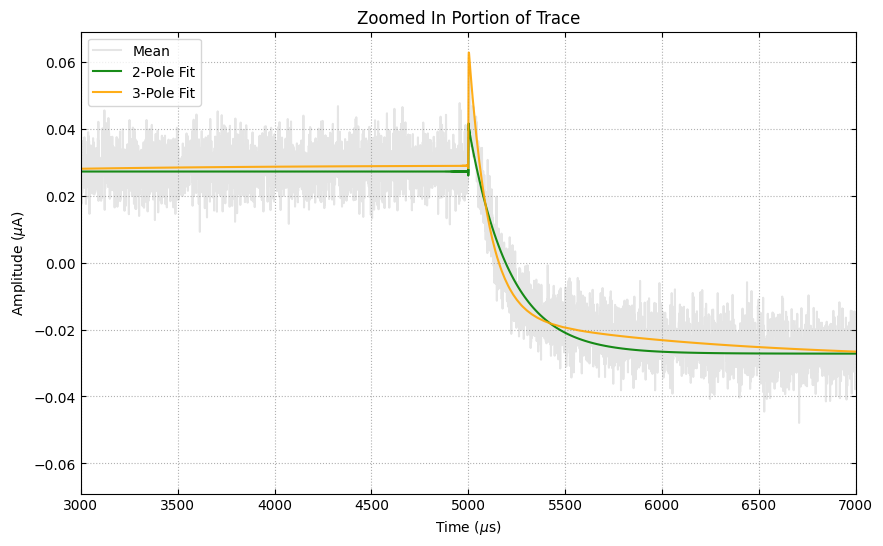

In [12]:
# example with 3 pole fit 

# bounds (same as default for loop gain>1)
# Needs to have all parameters (including fixed parameters), bound ignored for fixed parameter
bounds = (
    np.array((0.0, -np.inf, -np.inf, -np.inf, 0.0, 0.0, -np.inf)),
    np.array((np.inf, 0.0, 0.0, 0.0, np.inf, np.inf, np.inf))
)

# let's fix  for example tau3
# Note that for fixed parameters, the guessed value is used and boun
lgcfix = np.array([False,True,False,False, False, True,True])

# initial guess parameters (or value used for fixed parameters)
#  None if default guess
guess_params = np.array([None, None, None, None, None, 1e-3, None])

# fit
didvfit.dofit(3, bounds=bounds, guess_params=guess_params,
             lgcfix=lgcfix, guess_isloopgainsub1=False, verbose=2)


# results
result3b = didvfit.fitresult(3)
pprint(result3b['params'])

# plot
didvfit.plot_zoomed_in_trace(zoomfactor=0.4)

In [13]:
didvfit.calc_smallsignal_params(biasparams=true_params)

INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
